# Analyzing Sentence Structure

## Grammatical Dilemmas

### Ubiquitous Ambiguity

Here's a well known example of ambiguity in a sentence, where the structure of the sentence could be defined in multiple ways:

In [1]:
import nltk

In [2]:
groucho_grammar = nltk.CFG.fromstring("""
 S -> NP VP
 PP -> P NP
 NP -> Det N | Det N PP | 'I'
 VP -> V NP | VP PP
 Det -> 'an' | 'my'
 N -> 'elephant' | 'pajamas'
 V -> 'shot'
 P -> 'in'
""")

In [3]:
sent = ['I', 'shot', 'an', 'elephant', 'in', 'my', 'pajamas']

In [4]:
parser = nltk.ChartParser(groucho_grammar)
for tree in parser.parse(sent):
    print(tree)

(S
  (NP I)
  (VP
    (VP (V shot) (NP (Det an) (N elephant)))
    (PP (P in) (NP (Det my) (N pajamas)))))
(S
  (NP I)
  (VP
    (V shot)
    (NP (Det an) (N elephant) (PP (P in) (NP (Det my) (N pajamas))))))


## Context Free Grammar

### A Simple Grammar

An example of a simple context free grammar:

In [5]:
grammar1 = nltk.CFG.fromstring("""
  S -> NP VP
  VP -> V NP | V NP PP
  PP -> P NP
  V -> "saw" | "ate" | "walked"
  NP -> "John" | "Mary" | "Bob" | Det N | Det N PP
  Det -> "a" | "an" | "the" | "my"
  N -> "man" | "dog" | "cat" | "telescope" | "park"
  P -> "in" | "on" | "by" | "with"
  """)

In [6]:
sent = "Mary saw Bob".split()
rd_parser = nltk.RecursiveDescentParser(grammar1)
for tree in rd_parser.parse(sent):
    print(tree)

(S (NP Mary) (VP (V saw) (NP Bob)))


### Recursion in Syntactic Structure

In [7]:
grammar2 = nltk.CFG.fromstring("""
  S  -> NP VP
  NP -> Det Nom | PropN
  Nom -> Adj Nom | N
  VP -> V Adj | V NP | V S | V NP PP
  PP -> P NP
  PropN -> 'Buster' | 'Chatterer' | 'Joe'
  Det -> 'the' | 'a'
  N -> 'bear' | 'squirrel' | 'tree' | 'fish' | 'log'
  Adj  -> 'angry' | 'frightened' |  'little' | 'tall'
  V ->  'chased'  | 'saw' | 'said' | 'thought' | 'was' | 'put'
  P -> 'on'
  """)

In [8]:
rd_parser = nltk.RecursiveDescentParser(grammar2)

In [11]:
sent = "the angry bear chased the frightened little squirrel".split()

In [12]:
for tree in rd_parser.parse(sent):
    print(tree)

(S
  (NP (Det the) (Nom (Adj angry) (Nom (N bear))))
  (VP
    (V chased)
    (NP
      (Det the)
      (Nom (Adj frightened) (Nom (Adj little) (Nom (N squirrel)))))))


In [13]:
sent = "Chatterer said Buster thought the tree was tall".split()

In [14]:
for tree in rd_parser.parse(sent):
    print(tree)

(S
  (NP (PropN Chatterer))
  (VP
    (V said)
    (S
      (NP (PropN Buster))
      (VP
        (V thought)
        (S (NP (Det the) (Nom (N tree))) (VP (V was) (Adj tall)))))))


## Parsing With Context Free Grammar

Taking a look at the different ways of parsing a context free grammar:

### Recursive Descent Parsing

In [17]:
rd_parser = nltk.RecursiveDescentParser(grammar1)
sent = 'Mary saw a dog'.split()
for tree in rd_parser.parse(sent):
    print(tree)

(S (NP Mary) (VP (V saw) (NP (Det a) (N dog))))


### Shift Reduce Parsing

In [18]:
sr_parser = nltk.ShiftReduceParser(grammar1)
sent = 'Mary saw a dog'.split()
for tree in sr_parser.parse(sent):
    print(tree)

(S (NP Mary) (VP (V saw) (NP (Det a) (N dog))))


### Well Formed Substring Tables

In [33]:
def init_wfst(tokens, grammar):
    numtokens = len(tokens)
    wfst = [[None for i in range(numtokens+1)] for j in range(numtokens+1)]
    for i in range(numtokens):
        productions = grammar.productions(rhs=tokens[i])
        wfst[i][i+1] = productions[0].lhs()
    return wfst

In [34]:
def complete_wfst(wfst, tokens, grammar, trace=False):
    index = dict((p.rhs(), p.lhs()) for p in grammar.productions())
    numtokens = len(tokens)
    for span in range(2, numtokens+1):
        for start in range(numtokens+1-span):
            end = start + span
            for mid in range(start+1, end):
                nt1, nt2 = wfst[start][mid], wfst[mid][end]
                if nt1 and nt2 and (nt1,nt2) in index:
                    wfst[start][end] = index[(nt1,nt2)]
                    if trace:
                        print("[%s] %3s [%s] %3s [%s] ==> [%s] %3s [%s]" % \
                        (start, nt1, mid, nt2, end, start, index[(nt1,nt2)], end))
    return wfst

In [35]:
def display(wfst, tokens):
    print('\nWFST ' + ' '.join(("%-4d" % i) for i in range(1, len(wfst))))
    for i in range(len(wfst)-1):
        print("%d   " % i, end=" ")
        for j in range(1, len(wfst)):
            print("%-4s" % (wfst[i][j] or '.'), end=" ")
        print()

In [36]:
tokens = "I shot an elephant in my pajamas".split()

In [37]:
groucho_grammar.productions()

[S -> NP VP,
 PP -> P NP,
 NP -> Det N,
 NP -> Det N PP,
 NP -> 'I',
 VP -> V NP,
 VP -> VP PP,
 Det -> 'an',
 Det -> 'my',
 N -> 'elephant',
 N -> 'pajamas',
 V -> 'shot',
 P -> 'in']

In [42]:
wfst0 = init_wfst(tokens, groucho_grammar)

In [43]:
display(wfst0, tokens)


WFST 1    2    3    4    5    6    7   
0    NP   .    .    .    .    .    .    
1    .    V    .    .    .    .    .    
2    .    .    Det  .    .    .    .    
3    .    .    .    N    .    .    .    
4    .    .    .    .    P    .    .    
5    .    .    .    .    .    Det  .    
6    .    .    .    .    .    .    N    


In [45]:
wfst1 = complete_wfst(wfst0, tokens, groucho_grammar)
display(wfst1, tokens)


WFST 1    2    3    4    5    6    7   
0    NP   .    .    S    .    .    S    
1    .    V    .    VP   .    .    VP   
2    .    .    Det  NP   .    .    .    
3    .    .    .    N    .    .    .    
4    .    .    .    .    P    .    PP   
5    .    .    .    .    .    Det  NP   
6    .    .    .    .    .    .    N    


In [47]:
# Tracing how the WFST is being produced
wfst1 = complete_wfst(wfst0, tokens, groucho_grammar, trace=True)

[2] Det [3]   N [4] ==> [2]  NP [4]
[5] Det [6]   N [7] ==> [5]  NP [7]
[1]   V [2]  NP [4] ==> [1]  VP [4]
[4]   P [5]  NP [7] ==> [4]  PP [7]
[0]  NP [1]  VP [4] ==> [0]   S [4]
[1]  VP [4]  PP [7] ==> [1]  VP [7]
[0]  NP [1]  VP [7] ==> [0]   S [7]


## Dependencies and Dependency Grammar

While Phrase structure grammar is concerned with how words and sequences of words combine to form constituents, dependency grammar focuses on how words relate to other words.

Below is one way of encoding a dependency grammar in NLTK. Note that it does not capture the type of dependency. 

In [49]:
groucho_dep_grammar = nltk.DependencyGrammar.fromstring("""
'shot' -> 'I' | 'elephant' | 'in'
'elephant' -> 'an' | 'in'
'in' -> 'pajamas'
'pajamas' -> 'my'
""")

In [50]:
print(groucho_dep_grammar)

Dependency grammar with 7 productions
  'shot' -> 'I'
  'shot' -> 'elephant'
  'shot' -> 'in'
  'elephant' -> 'an'
  'elephant' -> 'in'
  'in' -> 'pajamas'
  'pajamas' -> 'my'


A dependency graph is projective if, when all the words are written in linear order, the edges can be drawn above the words without crossing. 

The next example shows how groucho_dep_grammar provides an alternative approach to capturing the attachment ambiguity that we examined earlier with phrase structure grammar.

In [51]:
pdp = nltk.ProjectiveDependencyParser(groucho_dep_grammar)
sent = 'I shot an elephant in my pajamas'.split()
trees = pdp.parse(sent)
for tree in trees:
    print(tree)

(shot I (elephant an (in (pajamas my))))
(shot I (elephant an) (in (pajamas my)))


## Grammar Development

### Treebanks and Grammar

The `corpus` module defines the `treebank` corpus reader which contains 1 10% sample of the Penn Treebank corpus.

In [55]:
from nltk.corpus import treebank
t = treebank.parsed_sents("wsj_0001.mrg")[0]

In [56]:
print(t)

(S
  (NP-SBJ
    (NP (NNP Pierre) (NNP Vinken))
    (, ,)
    (ADJP (NP (CD 61) (NNS years)) (JJ old))
    (, ,))
  (VP
    (MD will)
    (VP
      (VB join)
      (NP (DT the) (NN board))
      (PP-CLR (IN as) (NP (DT a) (JJ nonexecutive) (NN director)))
      (NP-TMP (NNP Nov.) (CD 29))))
  (. .))


We can use this data to develop a grammar. 

Let's build a function to find the verbs that take sentenial complements. Assuming we already have a production of the form VP -> Vs S, this information enables us to identify particular verbs that would be included in the expansion of Vs.

In [58]:
def filter(tree):
    child_nodes = [child.label() for child in tree
                   if isinstance(child, nltk.Tree)]
    return (tree.label() == 'VP') and ('S' in child_nodes)

In [60]:
results = [subtree for tree in treebank.parsed_sents() for subtree in tree.subtrees(filter)]

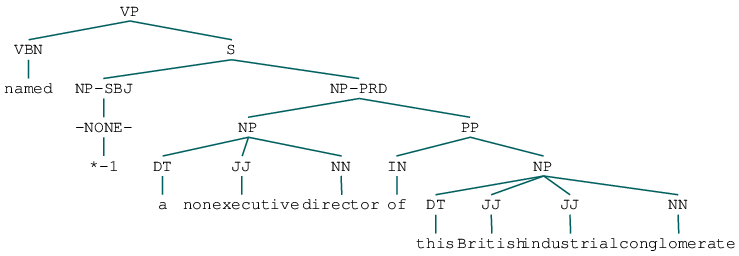

In [63]:
results[0]

The Prepositional Phrase Attachment Corpus, nltk.corpus.ppattach is another source of information about the valency of particular verbs. 

Using a technique below, we find pairs of prepositional phrases where the preposition and noun are fixed, but where the choice of verb determines whether the prepositional phrase is attached to the VP or to the NP.

In [69]:
from collections import defaultdict
entries = nltk.corpus.ppattach.attachments('training')
table = defaultdict(lambda: defaultdict(set))

In [70]:
for entry in entries:
    key = entry.noun1 + '-' + entry.prep + '-' + entry.noun2
    table[key][entry.attachment].add(entry.verb)

In [73]:
for key in sorted(table):
    if len(table[key]) > 1:
        print(key, 'N:', sorted(table[key]['N']), 'V:', sorted(table[key]['V']))

%-below-level N: ['left'] V: ['be']
%-from-year N: ['was'] V: ['declined', 'dropped', 'fell', 'grew', 'increased', 'plunged', 'rose', 'was']
%-in-August N: ['was'] V: ['climbed', 'fell', 'leaping', 'rising', 'rose']
%-in-September N: ['increased'] V: ['climbed', 'declined', 'dropped', 'edged', 'fell', 'grew', 'plunged', 'rose', 'slipped']
%-in-week N: ['declined'] V: ['was']
%-to-% N: ['add', 'added', 'backed', 'be', 'cut', 'go', 'grow', 'increased', 'increasing', 'is', 'offer', 'plummet', 'reduce', 'rejected', 'rise', 'risen', 'shaved', 'wants', 'yield', 'zapping'] V: ['fell', 'rise', 'slipped']
%-to-million N: ['declining'] V: ['advanced', 'climbed', 'cutting', 'declined', 'declining', 'dived', 'dropped', 'edged', 'fell', 'gained', 'grew', 'increased', 'jump', 'jumped', 'plunged', 'rising', 'rose', 'slid', 'slipped', 'soared', 'tumbled']
1-to-21 N: ['dropped'] V: ['dropped']
1-to-33 N: ['gained'] V: ['dropped', 'fell', 'jumped']
1-to-4 N: ['added'] V: ['gained']
1-to-47 N: ['jumped']

### Weighted Grammar

Examining instances of prepositional dative and double object constructions involving the verb `give`

In [74]:
def give(t):
    return t.label() == 'VP' and len(t) > 2 and t[1].label() == 'NP'\
           and (t[2].label() == 'PP-DTV' or t[2].label() == 'NP')\
           and ('give' in t[0].leaves() or 'gave' in t[0].leaves())
def sent(t):
    return ' '.join(token for token in t.leaves() if token[0] not in '*-0')
def print_node(t, width):
        output = "%s %s: %s / %s: %s" %\
            (sent(t[0]), t[1].label(), sent(t[1]), t[2].label(), sent(t[2]))
        if len(output) > width:
            output = output[:width] + "..."
        print(output)

In [76]:
for tree in nltk.corpus.treebank.parsed_sents():
     for t in tree.subtrees(give): print_node(t, 72)

gave NP: the chefs / NP: a standing ovation
give NP: advertisers / NP: discounts for maintaining or increasing ad sp...
give NP: it / PP-DTV: to the politicians
gave NP: them / NP: similar help
give NP: them / NP: 
give NP: only French history questions / PP-DTV: to students in a Europe...
give NP: federal judges / NP: a raise
give NP: consumers / NP: the straight scoop on the U.S. waste crisis
gave NP: Mitsui / NP: access to a high-tech medical product
give NP: Mitsubishi / NP: a window on the U.S. glass industry
give NP: much thought / PP-DTV: to the rates she was receiving , nor to ...
give NP: your Foster Savings Institution / NP: the gift of hope and free...
give NP: market operators / NP: the authority to suspend trading in futu...
gave NP: quick approval / PP-DTV: to $ 3.18 billion in supplemental appr...
give NP: the Transportation Department / NP: up to 50 days to review any...
give NP: the president / NP: such power
give NP: me / NP: the heebie-jeebies
give NP: holders / NP: 

A probabilistic context free grammar (or PCFG) is a context free grammar that associates a probability with each of its productions. 

The probability of a parse generated by a PCFG is the product of the probabilities of the productions used to generate it.

In [77]:
grammar = nltk.PCFG.fromstring("""
    S    -> NP VP              [1.0]
    VP   -> TV NP              [0.4]
    VP   -> IV                 [0.3]
    VP   -> DatV NP NP         [0.3]
    TV   -> 'saw'              [1.0]
    IV   -> 'ate'              [1.0]
    DatV -> 'gave'             [1.0]
    NP   -> 'telescopes'       [0.8]
    NP   -> 'Jack'             [0.2]
    """)

In [78]:
print(grammar)

Grammar with 9 productions (start state = S)
    S -> NP VP [1.0]
    VP -> TV NP [0.4]
    VP -> IV [0.3]
    VP -> DatV NP NP [0.3]
    TV -> 'saw' [1.0]
    IV -> 'ate' [1.0]
    DatV -> 'gave' [1.0]
    NP -> 'telescopes' [0.8]
    NP -> 'Jack' [0.2]


In [80]:
viterbi_parser = nltk.ViterbiParser(grammar)
for tree in viterbi_parser.parse(['Jack', 'saw', 'telescopes']): 
    print(tree)

(S (NP Jack) (VP (TV saw) (NP telescopes))) (p=0.064)


Further Reading: https://www.nltk.org/book/ch08.html